## Caution: important experiment, please do not adjust

The contents within this file are for running a publication-quality experiment and producing the associated figures and results. As such, it is finely tuned for specific high-quality graphics using the `primary.mplstyle` file. Please do not adjust. If you need to replicate results on your local system, please create a new notebook and copy contents from here.

# Landscape Detection with Generic Reconstructions

In this experiment, the ability for various reconstruction-based algorithms to rank landscapes containing novel content is investigated.

In [1]:
import sys
sys.path.append('../..')  # Expose top level program access

import time
import pickle
import logging
import torch
import numpy as np
import pandas as pd
import seaborn as sns
import pytorch_lightning as pl
import matplotlib.pyplot as plt

from functools import reduce
from pathlib import Path

from modules.cae_base_module import CAEBaseModule
from modules.vae_base_module import VAEBaseModule
from modules.aae_base_module import AAEBaseModule
from modules.pca_base_module import PCABaseModule
from models import supported_models
from datasets import supported_datamodules
from utils import tools, metrics, supported_preprocessing_transforms
from utils.dtypes import *

logging.getLogger("matplotlib").setLevel(logging.WARNING)  # Suppress verbose font warnings from matplotlib

In [2]:
# Import configurations and paths to logged models
root = Path.cwd().parents[1]
log_path = root / 'logs' / 'LunarAnalogueDataModule'
paths_to_archived_models = list(Path(log_path).glob('**/archive_v*'))

print('Found archived models:\n------')
print('\n'.join([f'{p.parent.name}/{p.name}' for p in paths_to_archived_models]))

Found archived models:
------
BaselineVAE/archive_v2_2021-05-06
BaselineVAE/archive_v1_2021-05-06
BaselineCAE/archive_v3_2021-05-06
BaselineCAE/archive_v2_2021-05-06
BaselineCAE/archive_v1_2021-04-12
BaselineAAE/archive_v1_2021-05-06


In [3]:
from experiments.helpers import load_modules

module_catalog, datamodule, _ = load_modules(paths_to_archived_models)

Loading state dict for: BaselineVAE/archive_v2_2021-05-06
Loading state dict for: BaselineVAE/archive_v1_2021-05-06
Loading state dict for: BaselineCAE/archive_v3_2021-05-06
Loading state dict for: BaselineCAE/archive_v2_2021-05-06
Loading state dict for: BaselineCAE/archive_v1_2021-04-12
Loading state dict for: BaselineAAE/archive_v1_2021-05-06


In [4]:
# Collect scores and labels on test set for all models and save to a dictionary
result_catalog = {}

for model_type, model_variants in module_catalog.items():
    start_time = time.time()
    
    for model_name, module in model_variants.items():
        
        test_novelty_scores = []
        test_novelty_labels = []
        short_name = model_type + '-' + model_name.split('_')[1]
        if short_name not in result_catalog:
            result_catalog[short_name] = {
                'scores': [], 
                'labels': []
            }
        print(f'------\n{short_name}\n------')
        
        # Handle the PCA and autoencoder frameworks separately
        if 'PCA' in short_name:
            test_novelty_scores = module.transform_pipeline(datamodule)
            test_novelty_labels = pca_test_labels
        else:
        
            # Set the model/components in evaluation mode
            if 'AAE' in model_type:
                module.encoder.eval()
                module.decoder.eval()
            else:
                module.model.eval()
        
            with torch.no_grad():
                for batch_nb, batch in enumerate(datamodule.test_dataloader()):

                    result = module.test_step(batch, batch_nb)

                    test_novelty_scores.extend(result['scores'])
                    test_novelty_labels.extend(result['labels'].cpu().numpy())
                    print(f'[BATCH {batch_nb}, {len(batch[0])} samples] Mean score: {np.mean(result["scores"])}')
                    
        result_catalog[short_name]['scores'] = test_novelty_scores
        result_catalog[short_name]['labels'] = test_novelty_labels
        print(f'{short_name} Time: {time.time() - start_time:.2f} s\n')

------
BaselineVAE-v2
------
[BATCH 0, 32 samples] Mean score: 0.6446191072463989
[BATCH 1, 32 samples] Mean score: 0.6338427066802979
[BATCH 2, 32 samples] Mean score: 0.6873399615287781
[BATCH 3, 32 samples] Mean score: 0.6669913530349731
[BATCH 4, 32 samples] Mean score: 0.7065211534500122
[BATCH 5, 32 samples] Mean score: 0.6724292039871216
[BATCH 6, 32 samples] Mean score: 0.6219462156295776
[BATCH 7, 32 samples] Mean score: 0.6501959562301636
[BATCH 8, 32 samples] Mean score: 0.7086296677589417
[BATCH 9, 32 samples] Mean score: 0.6931602358818054
[BATCH 10, 32 samples] Mean score: 0.696922779083252
[BATCH 11, 32 samples] Mean score: 0.6869221329689026
[BATCH 12, 32 samples] Mean score: 0.6808673143386841
[BATCH 13, 32 samples] Mean score: 0.6973098516464233
[BATCH 14, 32 samples] Mean score: 0.7132933139801025
[BATCH 15, 32 samples] Mean score: 0.7061588764190674
[BATCH 16, 32 samples] Mean score: 0.6855531930923462
[BATCH 17, 32 samples] Mean score: 0.657805323600769
[BATCH 18, 

[BATCH 16, 32 samples] Mean score: 0.3437269926071167
[BATCH 17, 32 samples] Mean score: 0.3242953419685364
[BATCH 18, 32 samples] Mean score: 0.30663490295410156
[BATCH 19, 32 samples] Mean score: 0.3308006525039673
[BATCH 20, 32 samples] Mean score: 0.373493492603302
[BATCH 21, 32 samples] Mean score: 0.33702266216278076
[BATCH 22, 32 samples] Mean score: 0.34675896167755127
[BATCH 23, 32 samples] Mean score: 0.3264821171760559
[BATCH 24, 32 samples] Mean score: 0.3401247262954712
[BATCH 25, 32 samples] Mean score: 0.32513341307640076
BaselineAAE-v1 Time: 248.15 s



BaselineVAE-v1: 583.3587646484375
BaselineCAE-v1: 89.07831573486328
BaselineAAE-v1: 267.5571594238281


2021-07-30 14:12:25,953 - WARNING - findfont: Font family ['serif'] not found. Falling back to DejaVu Sans.
2021-07-30 14:12:25,992 - WARNING - findfont: Font family ['serif'] not found. Falling back to DejaVu Sans.
2021-07-30 14:12:26,560 - DEBUG - STREAM b'IHDR' 16 13
2021-07-30 14:12:26,561 - DEBUG - STREAM b'PLTE' 41 48
2021-07-30 14:12:26,561 - DEBUG - STREAM b'tRNS' 101 15
2021-07-30 14:12:26,562 - DEBUG - STREAM b'pHYs' 128 9
2021-07-30 14:12:26,562 - DEBUG - STREAM b'IDAT' 149 96
2021-07-30 14:12:26,565 - DEBUG - STREAM b'IHDR' 16 13
2021-07-30 14:12:26,565 - DEBUG - STREAM b'PLTE' 41 48
2021-07-30 14:12:26,566 - DEBUG - STREAM b'tRNS' 101 15
2021-07-30 14:12:26,566 - DEBUG - STREAM b'pHYs' 128 9
2021-07-30 14:12:26,566 - DEBUG - STREAM b'IDAT' 149 129
2021-07-30 14:12:26,568 - DEBUG - STREAM b'IHDR' 16 13
2021-07-30 14:12:26,569 - DEBUG - STREAM b'PLTE' 41 48
2021-07-30 14:12:26,569 - DEBUG - STREAM b'tRNS' 101 15
2021-07-30 14:12:26,571 - DEBUG - STREAM b'pHYs' 128 9
2021-07-

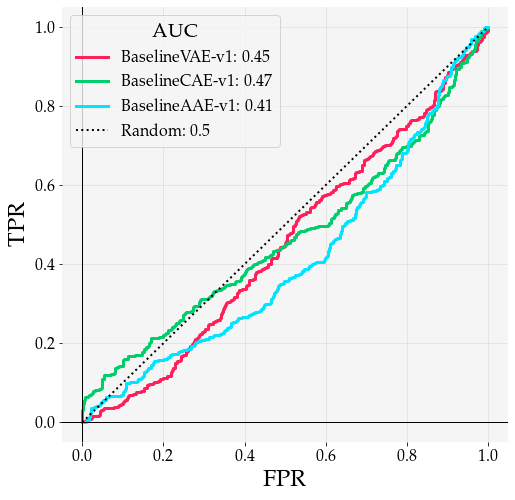

Random ROC AUC: 0.5


In [5]:
# Use standard custom styling
plt.style.use('../../utils/_extras/primary.mplstyle')

# Plot the ROC curves with AUCs for each model
fig, ax = plt.subplots(figsize=(8, 8))
for sn, results in result_catalog.items():
    
    if 'v1' not in sn:
        continue

    scores = results['scores']
    labels = results['labels']
    print(f'{sn}: {sum(scores)}')
    
    fpr, tpr, thresholds, auc = metrics.roc(scores, labels)
    
    ax.plot(fpr, tpr, label=f'{sn}: {auc:.2f}')
    
ax.set_xlabel('FPR')
ax.set_ylabel('TPR')
ax.plot([0., 1.], [0., 1.], 'k:', lw=2, label='Random: 0.5')
ax.legend(title='AUC')#, bbox_to_anchor=(1.05, 1.), loc='upper left')

ax.axhline(0, 0, c='k', lw=1)
ax.axvline(0, 0, c='k', lw=1)

plt.savefig('ROC-all_LunarAnalogueLandscape.pdf', format='pdf', bbox_inches='tight')
plt.show()
print('Random ROC AUC: 0.5')

2021-07-30 14:12:28,634 - DEBUG - STREAM b'IHDR' 16 13
2021-07-30 14:12:28,635 - DEBUG - STREAM b'PLTE' 41 48
2021-07-30 14:12:28,635 - DEBUG - STREAM b'tRNS' 101 15
2021-07-30 14:12:28,636 - DEBUG - STREAM b'pHYs' 128 9
2021-07-30 14:12:28,636 - DEBUG - STREAM b'IDAT' 149 160
2021-07-30 14:12:28,638 - DEBUG - STREAM b'IHDR' 16 13
2021-07-30 14:12:28,639 - DEBUG - STREAM b'PLTE' 41 48
2021-07-30 14:12:28,639 - DEBUG - STREAM b'tRNS' 101 15
2021-07-30 14:12:28,640 - DEBUG - STREAM b'pHYs' 128 9
2021-07-30 14:12:28,641 - DEBUG - STREAM b'IDAT' 149 181
2021-07-30 14:12:28,643 - DEBUG - STREAM b'IHDR' 16 13
2021-07-30 14:12:28,643 - DEBUG - STREAM b'PLTE' 41 48
2021-07-30 14:12:28,644 - DEBUG - STREAM b'tRNS' 101 15
2021-07-30 14:12:28,644 - DEBUG - STREAM b'pHYs' 128 9
2021-07-30 14:12:28,644 - DEBUG - STREAM b'IDAT' 149 156
2021-07-30 14:12:28,648 - DEBUG - STREAM b'IHDR' 16 13
2021-07-30 14:12:28,648 - DEBUG - STREAM b'PLTE' 41 48
2021-07-30 14:12:28,649 - DEBUG - STREAM b'tRNS' 101 15


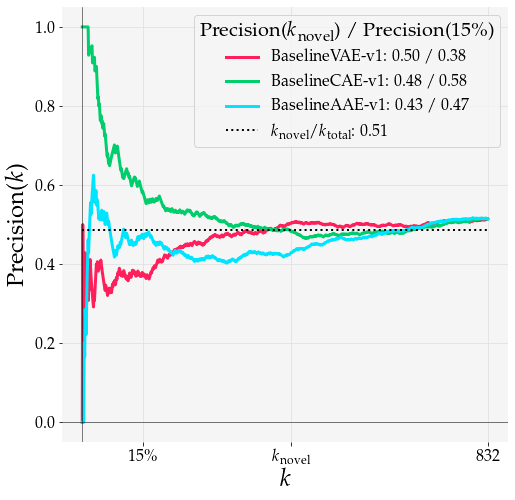

k nov  428
pat 15  124


In [6]:
# Plot the Precision(k) across all test images.
fig, ax = plt.subplots(figsize=(8, 8))
for sn, results in result_catalog.items():
    
    if 'v1' not in sn:
        continue
    
    scores = results['scores']
    labels = results['labels']
    pak = metrics.precision_at_k(scores, labels)

    uniques, counts = np.unique(labels, return_counts=True)
    random = counts.min() / counts.sum()
    pat15 =int(0.15 * counts.sum())

    ax.plot(pak, label=f'{sn}: {pak[int(sum(labels))]:.2f} / {pak[pat15]:.2}')
    
ax.plot([0, len(pak)], [random, random], 'k:', lw=2, 
        label='$k_{\mathrm{novel}}/k_{\mathrm{total}}$: '+f'{counts[1]/counts.sum():.2f}')

ax.set_xlabel('$k$')
ax.set_ylabel('Precision($k$)')
ax.legend(title='Precision($k_{\mathrm{novel}}$) / Precision(15\%)')#, bbox_to_anchor=(1.05, 1.), loc='upper left')

ax.set_xticks([pat15, counts[1], counts.sum()])
ax.set_xticklabels(['15\%', '$k_{\mathrm{novel}}$', counts.sum()])

# Draw axes for styling
ax.axhline(0, 0, c='k', lw=0.5)
ax.axvline(0, 0, c='k', lw=0.5)

plt.savefig('Pak-all_LunarAnalogueLandscape.pdf', format='pdf', bbox_inches='tight')
plt.show()

print('k nov ', counts[1])
print('pat 15 ', pat15)

BaselineVAE-v2


2021-07-30 14:12:29,246 - DEBUG - STREAM b'IHDR' 16 13
2021-07-30 14:12:29,246 - DEBUG - STREAM b'PLTE' 41 48
2021-07-30 14:12:29,246 - DEBUG - STREAM b'tRNS' 101 15
2021-07-30 14:12:29,247 - DEBUG - STREAM b'pHYs' 128 9
2021-07-30 14:12:29,247 - DEBUG - STREAM b'IDAT' 149 953
2021-07-30 14:12:29,256 - DEBUG - STREAM b'IHDR' 16 13
2021-07-30 14:12:29,256 - DEBUG - STREAM b'PLTE' 41 48
2021-07-30 14:12:29,257 - DEBUG - STREAM b'tRNS' 101 15
2021-07-30 14:12:29,257 - DEBUG - STREAM b'pHYs' 128 9
2021-07-30 14:12:29,257 - DEBUG - STREAM b'IDAT' 149 67
2021-07-30 14:12:29,260 - DEBUG - STREAM b'IHDR' 16 13
2021-07-30 14:12:29,260 - DEBUG - STREAM b'PLTE' 41 48
2021-07-30 14:12:29,261 - DEBUG - STREAM b'tRNS' 101 15
2021-07-30 14:12:29,264 - DEBUG - STREAM b'pHYs' 128 9
2021-07-30 14:12:29,265 - DEBUG - STREAM b'IDAT' 149 93
2021-07-30 14:12:29,266 - DEBUG - STREAM b'IHDR' 16 13
2021-07-30 14:12:29,267 - DEBUG - STREAM b'PLTE' 41 48
2021-07-30 14:12:29,267 - DEBUG - STREAM b'tRNS' 101 15
20

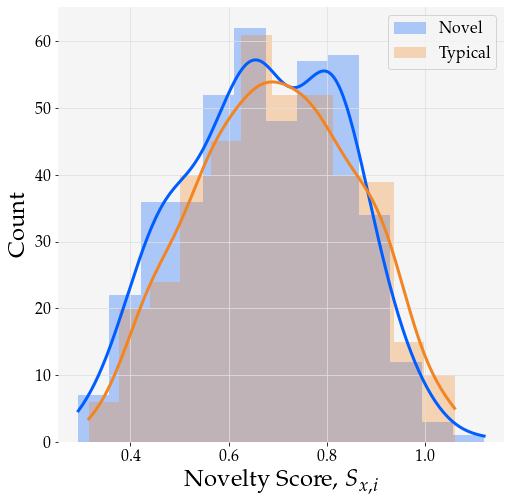

BaselineVAE-v1


2021-07-30 14:12:29,627 - DEBUG - STREAM b'IHDR' 16 13
2021-07-30 14:12:29,627 - DEBUG - STREAM b'PLTE' 41 48
2021-07-30 14:12:29,627 - DEBUG - STREAM b'tRNS' 101 15
2021-07-30 14:12:29,628 - DEBUG - STREAM b'pHYs' 128 9
2021-07-30 14:12:29,628 - DEBUG - STREAM b'IDAT' 149 114


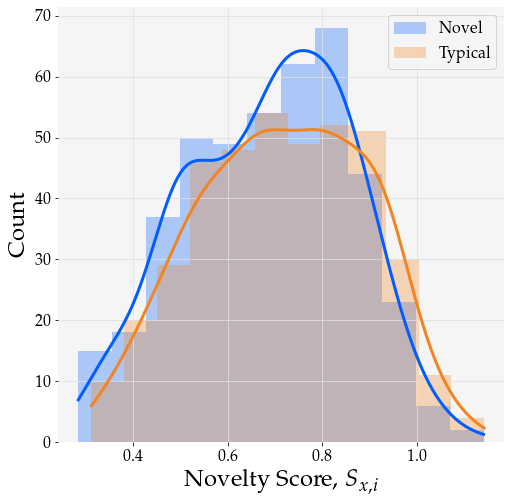

2021-07-30 14:12:29,953 - DEBUG - STREAM b'IHDR' 16 13
2021-07-30 14:12:29,953 - DEBUG - STREAM b'PLTE' 41 48
2021-07-30 14:12:29,954 - DEBUG - STREAM b'tRNS' 101 15
2021-07-30 14:12:29,954 - DEBUG - STREAM b'pHYs' 128 9
2021-07-30 14:12:29,954 - DEBUG - STREAM b'IDAT' 149 144
2021-07-30 14:12:29,956 - DEBUG - STREAM b'IHDR' 16 13


BaselineCAE-v3


2021-07-30 14:12:29,957 - DEBUG - STREAM b'PLTE' 41 48
2021-07-30 14:12:29,957 - DEBUG - STREAM b'tRNS' 101 15
2021-07-30 14:12:29,957 - DEBUG - STREAM b'pHYs' 128 9
2021-07-30 14:12:29,958 - DEBUG - STREAM b'IDAT' 149 119
2021-07-30 14:12:29,961 - DEBUG - STREAM b'IHDR' 16 13
2021-07-30 14:12:29,961 - DEBUG - STREAM b'PLTE' 41 48
2021-07-30 14:12:29,962 - DEBUG - STREAM b'tRNS' 101 15
2021-07-30 14:12:29,962 - DEBUG - STREAM b'pHYs' 128 9
2021-07-30 14:12:29,962 - DEBUG - STREAM b'IDAT' 149 148
2021-07-30 14:12:29,964 - DEBUG - STREAM b'IHDR' 16 13
2021-07-30 14:12:29,965 - DEBUG - STREAM b'PLTE' 41 48
2021-07-30 14:12:29,965 - DEBUG - STREAM b'tRNS' 101 15
2021-07-30 14:12:29,965 - DEBUG - STREAM b'pHYs' 128 9
2021-07-30 14:12:29,966 - DEBUG - STREAM b'IDAT' 149 146
2021-07-30 14:12:29,973 - DEBUG - STREAM b'IHDR' 16 13
2021-07-30 14:12:29,974 - DEBUG - STREAM b'PLTE' 41 48
2021-07-30 14:12:29,974 - DEBUG - STREAM b'tRNS' 101 15
2021-07-30 14:12:29,974 - DEBUG - STREAM b'pHYs' 128 9


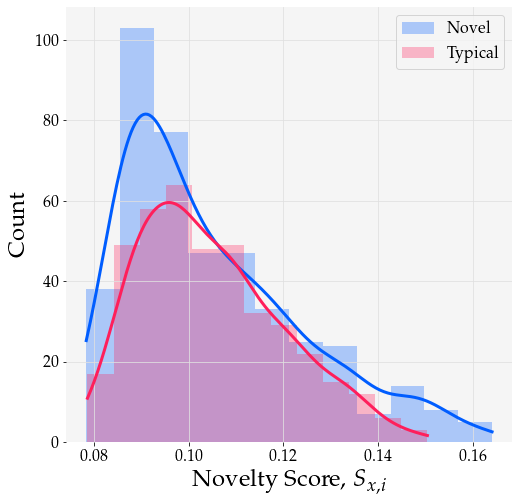

2021-07-30 14:12:30,317 - DEBUG - STREAM b'IHDR' 16 13
2021-07-30 14:12:30,317 - DEBUG - STREAM b'PLTE' 41 48
2021-07-30 14:12:30,317 - DEBUG - STREAM b'tRNS' 101 15
2021-07-30 14:12:30,318 - DEBUG - STREAM b'pHYs' 128 9
2021-07-30 14:12:30,318 - DEBUG - STREAM b'IDAT' 149 150


BaselineCAE-v2


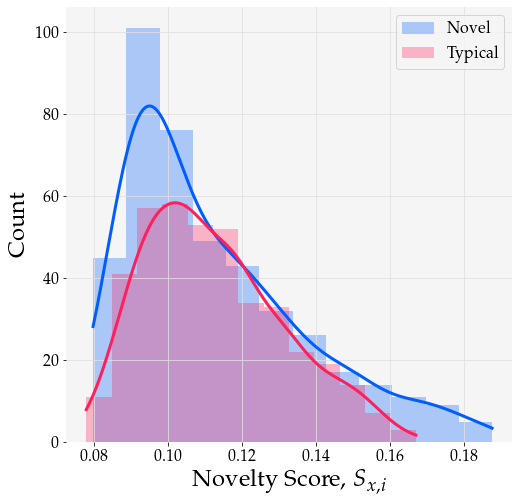

BaselineCAE-v1


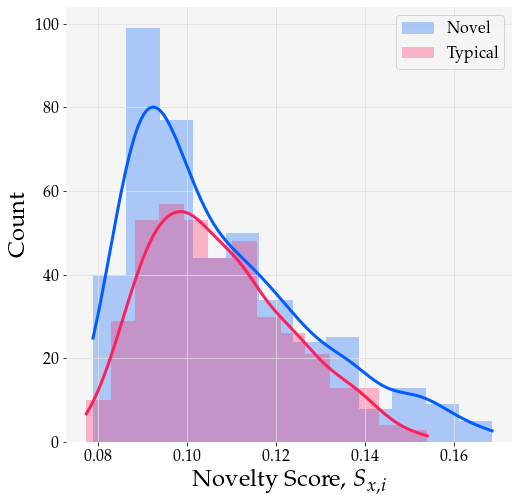

2021-07-30 14:12:30,984 - DEBUG - STREAM b'IHDR' 16 13
2021-07-30 14:12:30,984 - DEBUG - STREAM b'PLTE' 41 48
2021-07-30 14:12:30,985 - DEBUG - STREAM b'tRNS' 101 15
2021-07-30 14:12:30,985 - DEBUG - STREAM b'pHYs' 128 9
2021-07-30 14:12:30,985 - DEBUG - STREAM b'IDAT' 149 98


BaselineAAE-v1


2021-07-30 14:12:30,989 - DEBUG - STREAM b'IHDR' 16 13
2021-07-30 14:12:30,989 - DEBUG - STREAM b'PLTE' 41 48
2021-07-30 14:12:30,989 - DEBUG - STREAM b'tRNS' 101 15
2021-07-30 14:12:30,990 - DEBUG - STREAM b'pHYs' 128 9
2021-07-30 14:12:30,990 - DEBUG - STREAM b'IDAT' 149 128
2021-07-30 14:12:30,993 - DEBUG - STREAM b'IHDR' 16 13
2021-07-30 14:12:30,993 - DEBUG - STREAM b'PLTE' 41 48
2021-07-30 14:12:30,994 - DEBUG - STREAM b'tRNS' 101 15
2021-07-30 14:12:30,994 - DEBUG - STREAM b'pHYs' 128 9
2021-07-30 14:12:30,994 - DEBUG - STREAM b'IDAT' 149 127


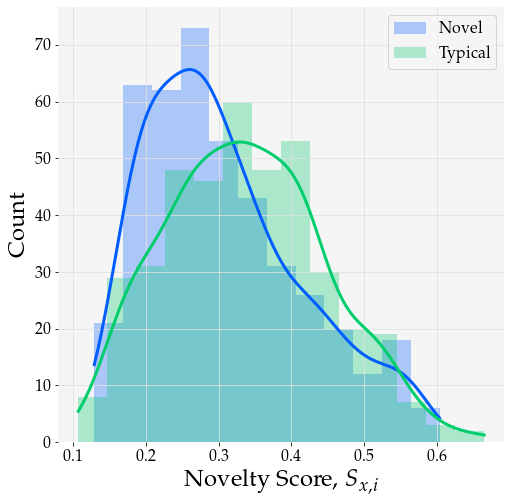

In [7]:
def score_density_vis_rc(rc_scores, labels, sn, color='C1'):
    
    labels = np.array(labels).astype(bool)
    rc_scores = np.array(rc_scores)
    
    fig, ax = plt.subplots(figsize=(8, 8))
    sns.histplot(data=rc_scores[labels], label='Novel', color='C5', fill=True, lw=0, alpha=0.3, kde=True)
    sns.histplot(data=rc_scores[~labels], label='Typical', color=color, fill=True, lw=0, alpha=0.3, kde=True)
    ax.set_xlabel('Novelty Score, $S_{x,i}$')
    plt.legend()
    plt.savefig(f'ReconstructionScoreDensity-{sn}-CuriosityMastcam.pdf', format='pdf', bbox_inches='tight')
    plt.show()

for sn, res in result_catalog.items():
    print(sn)
            
    rc_scores = res['scores']
    if 'AAE' in sn:
        color = 'C1'
    elif 'VAE' in sn:
        color = 'C6'
    else:
        color = 'C0'
    score_density_vis_rc(rc_scores, res['labels'], sn, color=color)